Device Data Columns: Index(['id', 'date', 'user', 'pc', 'activity'], dtype='object')
HTTP Data Columns: Index(['{M8H9-W9NL75TH-1322KOLO}', '01/04/2010 07:08:47', 'DTAA/AMA0606',
       'PC-1514', 'http://cnet.com'],
      dtype='object')
Logon Data Columns: Index(['id', 'date', 'user', 'pc', 'activity'], dtype='object')

📊 Merged User Activity Data Sample:
╒══════════╤══════════════╤═════════════════════╤══════════════════╤═════════╤═══════════════════╤══════════════╤══════════════╕
│          │ user         │ date                │ activity_logon   │ pc      │ activity_device   │   Anomaly_IF │ Risk Level   │
╞══════════╪══════════════╪═════════════════════╪══════════════════╪═════════╪═══════════════════╪══════════════╪══════════════╡
│ 57127474 │ DTAA/AJA0220 │ 2011-04-15 11:41:31 │ Logon            │ PC-3872 │ Connect           │            1 │ 🟢 Low Risk  │
├──────────┼──────────────┼─────────────────────┼──────────────────┼─────────┼───────────────────┼──────────────┼─────────────

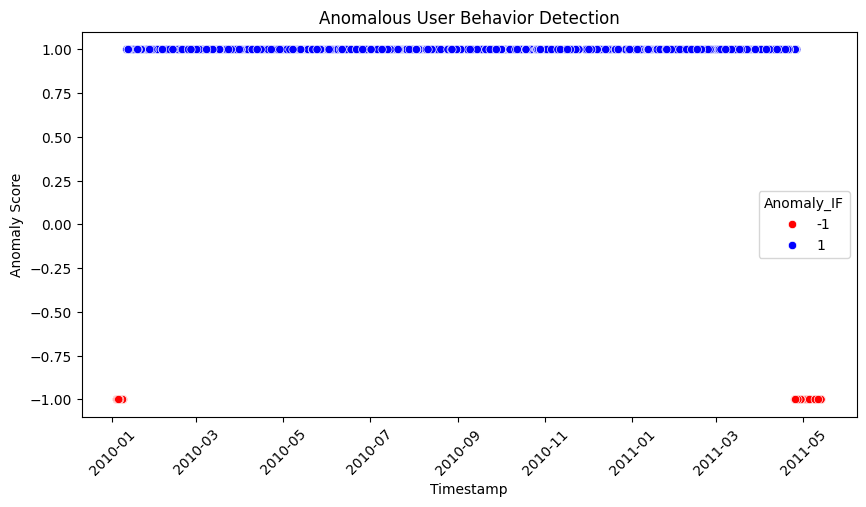


🚨 Flagged Insider Threats:
╒══════════╤══════════════╤═════════╤═════════════════════╤══════════════════╤═══════════════════╤══════════════╕
│          │ user         │ pc      │ date                │ activity_logon   │ activity_device   │ Risk Level   │
╞══════════╪══════════════╪═════════╪═════════════════════╪══════════════════╪═══════════════════╪══════════════╡
│ 60171035 │ DTAA/SLC0778 │ PC-3199 │ 2011-05-12 07:36:12 │ Logon            │ Connect           │ 🔴 High Risk │
├──────────┼──────────────┼─────────┼─────────────────────┼──────────────────┼───────────────────┼──────────────┤
│   203961 │ DTAA/LJR0772 │ PC-3780 │ 2010-01-05 07:54:56 │ Logon            │ Disconnect        │ 🔴 High Risk │
├──────────┼──────────────┼─────────┼─────────────────────┼──────────────────┼───────────────────┼──────────────┤
│ 59909744 │ DTAA/MMF0289 │ PC-1734 │ 2011-05-10 13:26:00 │ Logon            │ Connect           │ 🔴 High Risk │
├──────────┼──────────────┼─────────┼─────────────────────┼────

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from tabulate import tabulate

# Load real insider threat dataset from Kaggle (device, http, logon data)
device_data = pd.read_csv("dataset/device.csv", encoding="ISO-8859-1")
http_data = pd.read_csv("dataset/http.csv", encoding="ISO-8859-1")
logon_data = pd.read_csv("dataset/logon.csv", encoding="ISO-8859-1")

# Display column names to verify the correct format
print("Device Data Columns:", device_data.columns)
print("HTTP Data Columns:", http_data.columns)
print("Logon Data Columns:", logon_data.columns)

# Select relevant features based on actual dataset columns
device_features = ['user', 'activity', 'pc']
logon_features = ['user', 'date', 'activity', 'pc']

# Merge datasets based on 'user' and 'pc' columns
merged_data = pd.merge(logon_data[logon_features], device_data[device_features], on=['user', 'pc'], how='inner', suffixes=('_logon', '_device'))

# Reduce dataset size for faster execution
merged_data = merged_data.sample(5000, random_state=42)  # Limits to 5000 rows

# Convert timestamps to human-readable format
merged_data['date'] = pd.to_datetime(merged_data['date'])

# Convert timestamps to numerical format for model input
X = merged_data['date'].astype(int) / 10**9  # Convert back to numerical timestamp
X = X.values.reshape(-1, 1)  # Reshape for model input

# Train optimized anomaly detection model
isolation_forest = IsolationForest(contamination=0.05, random_state=42)
merged_data['Anomaly_IF'] = isolation_forest.fit_predict(X)

# Assign risk levels based on anomalies
def assign_risk(score):
    if score == -1:
        return "🔴 High Risk"
    return "🟢 Low Risk"

merged_data["Risk Level"] = merged_data["Anomaly_IF"].apply(assign_risk)

# Display dataset overview
print("\n📊 Merged User Activity Data Sample:")
print(tabulate(merged_data.head(), headers='keys', tablefmt='fancy_grid'))

# Visualizing Anomalies
plt.figure(figsize=(10, 5))
sns.scatterplot(x=merged_data['date'], y=merged_data['Anomaly_IF'], hue=merged_data['Anomaly_IF'], palette={-1: 'red', 1: 'blue'})
plt.title("Anomalous User Behavior Detection")
plt.xlabel("Timestamp")
plt.ylabel("Anomaly Score")
plt.xticks(rotation=45)
plt.show()

# Display flagged insider threats in a clean table format
risky_users = merged_data[merged_data['Anomaly_IF'] == -1]
print("\n🚨 Flagged Insider Threats:")
print(tabulate(risky_users[['user', 'pc', 'date', 'activity_logon', 'activity_device', 'Risk Level']], headers='keys', tablefmt='fancy_grid'))

# Summary Statistics
print(f"📌 Total Users Analyzed: {merged_data.shape[0]}")
print(f"🚨 Total Flagged Insider Threats: {risky_users.shape[0]}")
print(risky_users["activity_logon"].value_counts())

# Generate Report (CSV & HTML Only)
risky_users.to_csv("flagged_insider_threats.csv", index=False)
risky_users.to_html("flagged_insider_threats.html")
print("✅ Reports saved: 'flagged_insider_threats.csv' & 'flagged_insider_threats.html'")

print("🔴 **Red points in the graph indicate potential insider threats detected by AI models.**")